In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''

import argparse

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data import EMNISTLines2

## More challenging EMNISTLines

Now that we've seen the `IAMLines` dataset, we can make our synthetic dataset look more like it by changing the shape of the canvas into which we embed the sentence crops, and by adding data augmentations.

In [2]:
dataset = EMNISTLines2(args=argparse.Namespace())
dataset.prepare_data()
dataset.setup()
print(dataset)

EMNISTLines2 generating data for train...


[nltk_data] Downloading package brown to /home/sergeyk/work/fsdl/fsdl-
[nltk_data]     text-recognizer-2021/data/downloaded/nltk...
[nltk_data]   Unzipping corpora/brown.zip.
0.00B [00:00, ?B/s]

709MB [00:13, 56.4MB/s]                              


Computing SHA-256...
Unzipping EMNIST...
Loading training data from .mat file
Balancing classes to reduce amount of data
Saving to HDF5 in a compressed format...
Saving essential dataset parameters to text_recognizer/datasets...
Cleaning up...
EMNISTLines2 generating data for val...
EMNISTLines2 generating data for test...
EMNISTLines2 loading data from HDF5...


/home/sergeyk/miniconda3/envs/fsdl-text-recognizer-2021/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


EMNISTLines2 Dataset
Min overlap: 0.2
Max overlap: 0.5
Num classes: 83
Dims: (1, 56, 1024)
Output dims: (89, 1)
Train/val/test sizes: 10000, 2000, 2000
Batch x stats: (torch.Size([128, 1, 56, 1024]), torch.float32, tensor(0.), tensor(0.0181), tensor(0.1014), tensor(0.9989))
Batch y stats: (torch.Size([128, 89]), torch.int64, tensor(1), tensor(66))



In [3]:
def convert_y_label_to_string(y, dataset=dataset):
    # NOTE: we ignore padding tokens
    return ''.join([dataset.mapping[i] for i in y if i != 3])

y_example = dataset.data_train[0][1]
print(y_example, y_example.shape)
convert_y_label_to_string(y_example)

tensor([ 1, 48, 59,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]) torch.Size([89])


'<S>it<E>'

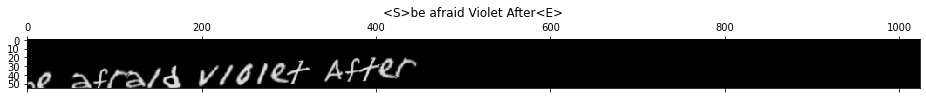

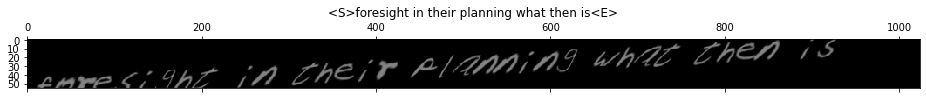

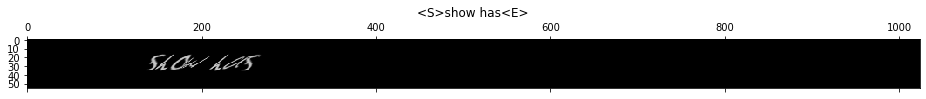

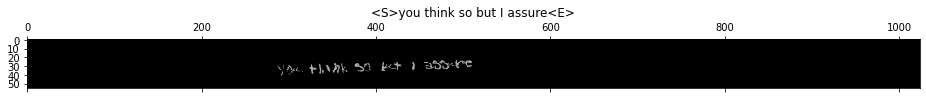

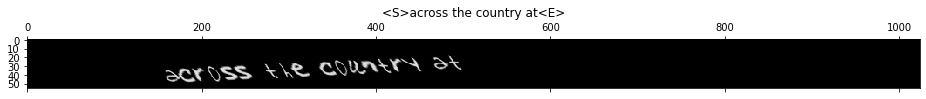

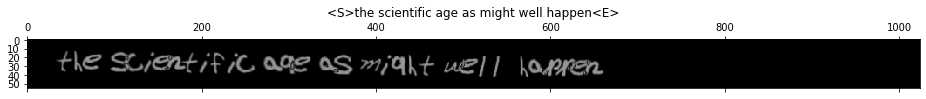

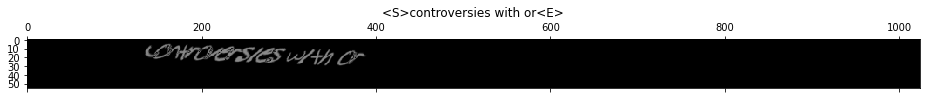

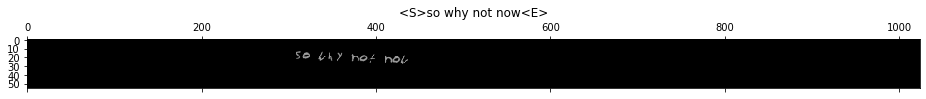

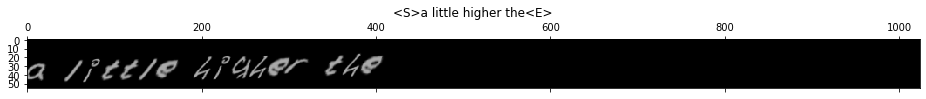

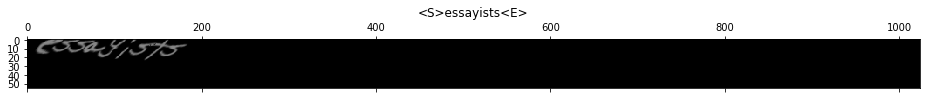

In [4]:
## Train

X, Y = next(iter(dataset.train_dataloader()))
for i in range(10):
    x, y = X[i], Y[i]
    sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(sentence)

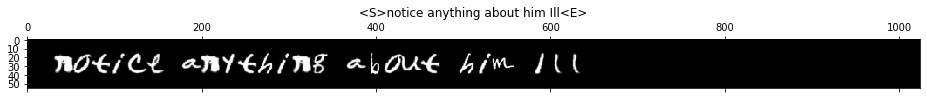

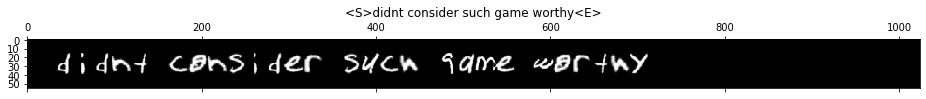

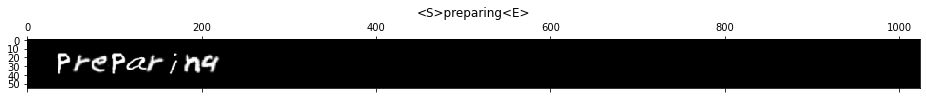

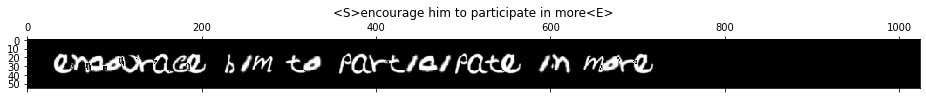

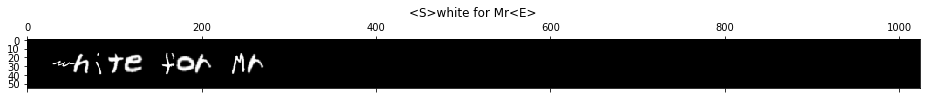

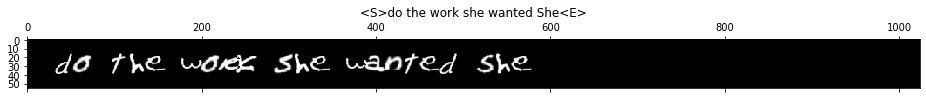

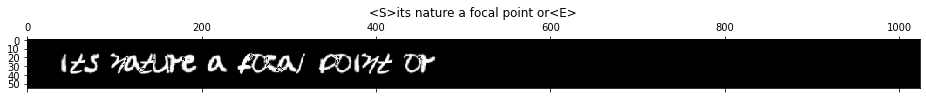

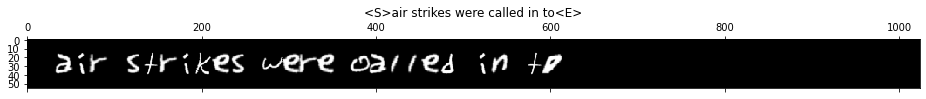

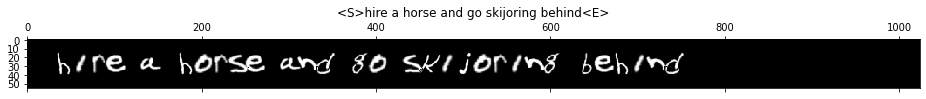

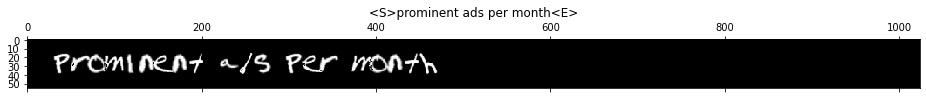

In [5]:
## Test

X, Y = next(iter(dataset.test_dataloader()))
for i in range(10):
    x, y = X[i], Y[i]
    sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(sentence)

## See predictions of a trained model

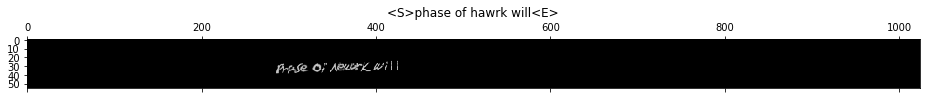

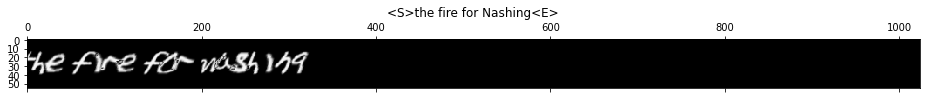

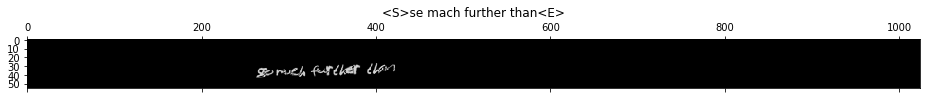

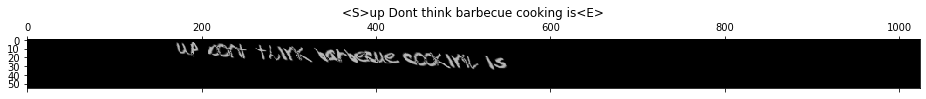

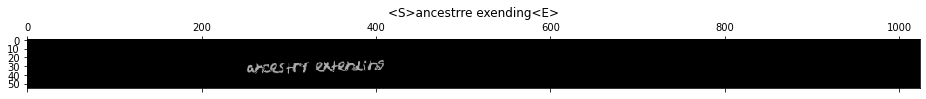

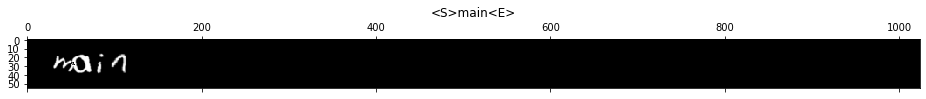

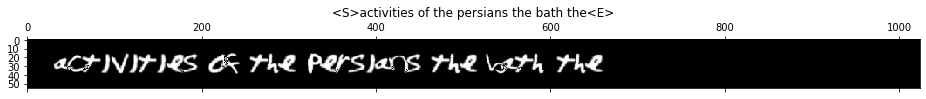

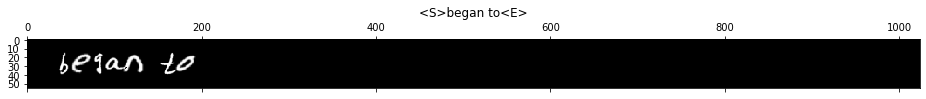

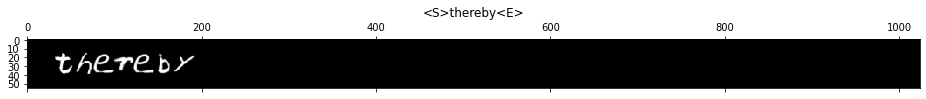

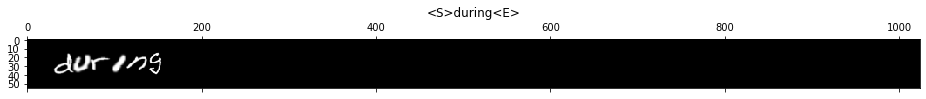

In [7]:
import argparse
from text_recognizer.lit_models import TransformerLitModel
from text_recognizer.models import LineCNNTransformer

model = LineCNNTransformer(
    data_config=dataset.config(),
    args=argparse.Namespace()
)
lit_model = TransformerLitModel.load_from_checkpoint(
    '../training/logs/default_fsdl-text-recognizer-2021-training/469_3ocpqryn/checkpoints/epoch=125-step=5039.ckpt',
    model=model,
    args=argparse.Namespace()
)

for i in range(5):
    x, y = dataset.data_train[i]
    pred = lit_model(x.unsqueeze(0))
    pred_sentence = ''.join(dataset.mapping[_] for _ in pred[0].tolist() if _ != 3)
    true_sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(pred_sentence)
    
for i in range(5):
    x, y = dataset.data_test[i]
    pred = lit_model(x.unsqueeze(0))
    pred_sentence = ''.join(dataset.mapping[_] for _ in pred[0].tolist() if _ != 3)
    true_sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(pred_sentence)